In [1]:
#Sept 8 2015
#This code is to examine the ferengi data to see whether a smoothing function can be applied to determine
# the 'correctable' regions of p_features, z, and surface brightness space. 
%matplotlib inline
from astropy.io import fits as pyfits
from astropy.table import Table,Column

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
import requests


#mpl.rcParams['text.usetex']=True
#mpl.rcParams['axes.linewidth'] = 3

In [2]:
def download_from_dropbox(url):
    
    local_filename = "{:}".format(url.split("/")[-1].split("?")[0])
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
            
    return local_filename

In [3]:
data=pyfits.open('/home/mel/Documents/GZ_HUBBLE/ferengi_debias/gzhubble/data/ferengi_data_with_categories.fits')
data=data[1].data

In [4]:
ferengi_filename = download_from_dropbox("https://www.dropbox.com/s/afif9k0gwihus3a/ferengi_data_with_categories.fits?dl=1")
data = pyfits.open(ferengi_filename)  
data=data[1].data

In [5]:
#Column names:
#p_features = p_features 
#redshift = sim_redshift
#surface brightness = mu_max_i

In [6]:
correctable=(data['Correctable_Category']=='correctable')
uncorrectable=(data['Correctable_Category']=='uncorrectable')
nei=(data['Correctable_Category']=='nei')
not_nei=(data['Correctable_Category']!='nei')

In [7]:
correctable_array=np.zeros((3,len(data[correctable])))
uncorrectable_array=np.zeros((3,len(data[uncorrectable])))
nei_array=np.zeros((3,len(data[nei])))
not_nei_array=np.zeros((3,len(data[not_nei])))

In [37]:
#Create array to store redshift, SB and p_features info for each category
#change discrete redshift into continuous for visualization purposes 
#ex: if sim_redshift = 0.3, chose random number between 0.25 and 0.35 instead. 
for i,row in enumerate(data[correctable]):
    z=round(row['sim_redshift']*1000,1)
    correctable_array[0][i]=random.randrange(z-50,z+50)/1000.
    correctable_array[1][i]=row['mu_max_i']
    correctable_array[2][i]=row['p_features']
for i,row in enumerate(data[uncorrectable]):
    z=round(row['sim_redshift']*1000,1)
    uncorrectable_array[0][i]=random.randrange(z-50,z+50)/1000.
    uncorrectable_array[1][i]=row['mu_max_i']
    uncorrectable_array[2][i]=row['p_features']
for i,row in enumerate(data[not_nei]):
    z=round(row['sim_redshift']*1000,1)
    not_nei_array[0][i]=random.randrange(z-50,z+50)/1000.
    not_nei_array[1][i]=row['mu_max_i']
    not_nei_array[2][i]=row['p_features']
for i,row in enumerate(data[nei]):
    z=round(row['sim_redshift']*1000,1)
    nei_array[0][i]=random.randrange(z-50,z+50)/1000.
    nei_array[1][i]=row['mu_max_i']
    nei_array[2][i]=row['p_features']

In [9]:
#Below: quick check to make sure the arrays were put together properly 

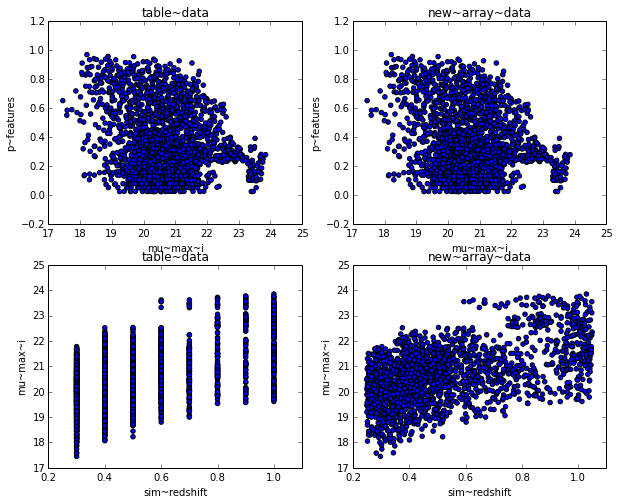

In [38]:
f=plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
ax1 = f.add_subplot(gs[0,0])
plt.scatter(data[correctable]['mu_max_i'],data[correctable]['p_features'])
plt.xlabel('mu~max~i')
plt.ylabel('p~features')
plt.title('table~data')
ax2 = f.add_subplot(gs[0,1])
plt.scatter(correctable_array[1],correctable_array[2])
plt.xlabel('mu~max~i')
plt.ylabel('p~features')
plt.title('new~array~data')
ax1 = f.add_subplot(gs[1,0])
plt.scatter(data[correctable]['sim_redshift'],data[correctable]['mu_max_i'])
plt.xlabel('sim~redshift')
plt.ylabel('mu~max~i')
plt.title('table~data')
ax2 = f.add_subplot(gs[1,1])
plt.scatter(correctable_array[0],correctable_array[1])
plt.xlabel('sim~redshift')
plt.ylabel('mu~max~i')
plt.title('new~array~data')

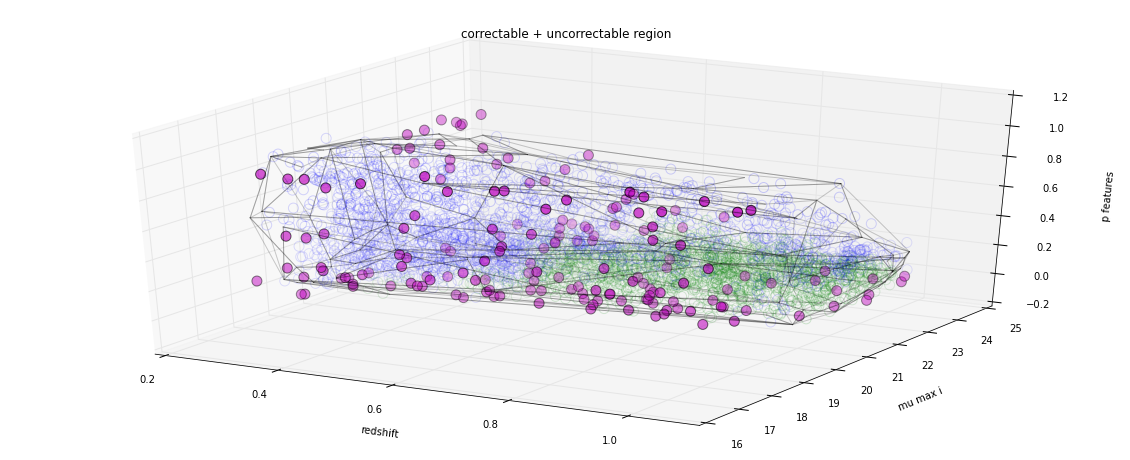

In [42]:
#First define a hull to encompass all non-nei galaxies: 
#Anything outside this hull in Hubble will be not be corrected 
#Anything inside this hull in Hubble will either be correctable or uncorrectable
all_points=not_nei_array.T
all_hull=ConvexHull(all_points)

#Just uncorrectable:
un_points=uncorrectable_array.T
hull=ConvexHull(un_points)

#3D plot of hull 
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(correctable_array[0], correctable_array[1], correctable_array[2], facecolors='none',edgecolors='b',alpha=.2,s=100,label='correctable')
ax.scatter(uncorrectable_array[0], uncorrectable_array[1], uncorrectable_array[2], facecolors='none',edgecolors='g',alpha=.2,s=100,label='uncorrectable')
ax.scatter(nei_array[0], nei_array[1], nei_array[2],facecolors='m',alpha=.8,s=100,label='nei')

for s in all_hull.simplices:
	ax.plot(all_points[s,0],all_points[s,1],all_points[s,2],'k-',alpha=.2)
ax.set_xlabel('redshift')
ax.set_ylabel('mu max i')
ax.set_zlabel('p features')
plt.title('correctable + uncorrectable region')

In [12]:
#function to determine whether a point 'p' is inside convex hull defined by points 'points'. 
def is_p_inside_hull(points,p):
    hull=ConvexHull(points)
    new_points=np.concatenate((points,p),axis=0)
    new_hull=ConvexHull(new_points)
    if list(hull.vertices)==list(new_hull.vertices):
        return True
    else:
        return False



In [13]:
#Function to count how many points are in hull:

def number_of_points_in_hull(this_array,hull_array):
    n_in_hull=0
    for row in this_array:
        this_point = np.array([row])
        if is_p_inside_hull(hull_array,this_point)==True:
            n_in_hull+=1
    return n_in_hull

In [14]:
#Function to remove points from uncorrectable hull until there is minimal overlap between the two regions
def new_convex_hull(total_points_to_remove,points_at_a_time):
    #This is the original array. 
    un_points=uncorrectable_array.T
    hull=ConvexHull(un_points)

    #first find the center of the 3D data: 
    z_center=np.median(un_points[:,0])
    mu_center=np.median(un_points[:,1])
    p_center=np.median(un_points[:,2])

    #now figure out distance to center for each point:
    distance_to_center=[]
    for row in un_points:
        distance_to_center.append(np.sqrt((row[0]-z_center)**2+(row[1]-mu_center)**2+(row[2]-p_center)**2))
    un_points=np.insert(un_points,3,distance_to_center,axis=1)


    #Eliminate the point farthest from the center, repeat until things are cool 

    #start by sorting array by distance from center 
    new_un_array=un_points[np.argsort(un_points[:,3])]
    #now delete that column because convexhull hates it
    new_un_array=np.delete(new_un_array,3,axis=1)


    #Now loop - eliminate point by point, recalculate hull, then check the ratio of correctable:uncorrectable points. Find the minimum. 
    i_list=[]
    co_fraction=[]
    un_fraction=[]
    N=len(new_un_array) 
    for i in range(0,total_points_to_remove/points_at_a_time):
        #delete furthest point from center
        for j in range(0,points_at_a_time):
            new_un_array=np.delete(new_un_array,len(new_un_array)-1,0)
        #new hull with furthest point removed
        new_hull=ConvexHull(new_un_array)
    
        #track how many correctable and uncorrectable points are in hull with each iteration: 
        i_list.append(points_at_a_time*i)
        co_fraction.append(float(number_of_points_in_hull(correctable_array.T,new_un_array))/len(correctable_array.T))
        un_fraction.append(float(number_of_points_in_hull(uncorrectable_array.T,new_un_array))/len(uncorrectable_array.T))
    return i_list,co_fraction,un_fraction,new_hull,new_un_array


In [15]:
#Try removing a 200 points, 10 at a time:
i_list,co_fraction,un_fraction,new_hull,new_un_array=new_convex_hull(200,10)


(-3, 200)

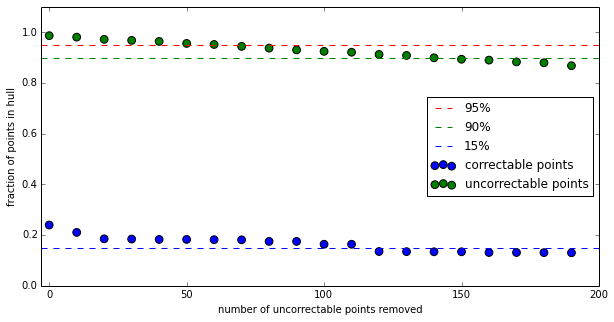

In [16]:
f=plt.figure(figsize=(10,5))
plt.scatter(i_list,co_fraction,label='correctable points',s=60)
plt.scatter(i_list,un_fraction,label='uncorrectable points',s=60,c='g')
plt.xlabel('number of uncorrectable points removed')
plt.ylabel('fraction of points in hull') 
plt.axhline(y=0.95,ls='dashed',label='95%',c='r')
plt.axhline(y=0.9,ls='dashed',label='90%',c='g')
plt.axhline(y=0.15,ls='dashed',label='15%',c='b')
plt.legend(loc='center right')
plt.ylim(0,1.1)
plt.xlim(-3,200)


In [17]:
#Based on above plot, determine how many points are appropriate to cut from hull to make final version:
N_to_cut=100
i_list,co_fraction,un_fraction,new_hull,new_un_array=new_convex_hull(N_to_cut,1)
print 'By excluding %s of %s uncorrectable galaxies when computing the uncorrectable hull region, %s%% of uncorrectable galaxies and %s%% of correctable galaxies remain in the uncorrectable region.' %(N_to_cut,len(uncorrectable_array.T),round(un_fraction[len(un_fraction)-1],3)*100.,round(co_fraction[len(co_fraction)-1],3)*100.
)

By excluding 100 of 1732 uncorrectable galaxies when computing the uncorrectable hull region, 93.0% of uncorrectable galaxies and 17.5% of correctable galaxies remain in the uncorrectable region.


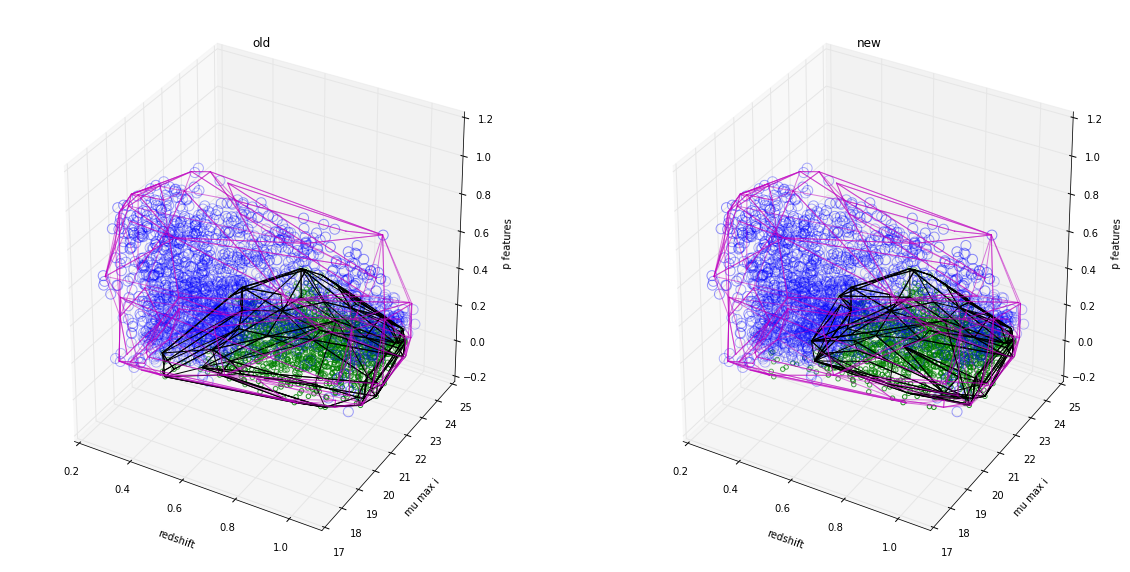

In [18]:
#3D plot of old hull 
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(correctable_array[0], correctable_array[1], correctable_array[2], facecolors='none',edgecolors='b',alpha=.5,s=100,label='correctable')
ax.scatter(uncorrectable_array[0], uncorrectable_array[1], uncorrectable_array[2], facecolors='none', edgecolors='g',label='uncorrectable')
for s in hull.simplices:
	ax.plot(un_points[s,0],un_points[s,1],un_points[s,2],'k-')
for s in all_hull.simplices:
	ax.plot(all_points[s,0],all_points[s,1],all_points[s,2],'m-',alpha=.5)

#ax.scatter(nei_array[0], nei_array[1], nei_array[2], facecolors='none',edgecolors='m',label='nei')
ax.set_xlabel('redshift')
ax.set_ylabel('mu max i')
ax.set_zlabel('p features')
plt.title('old')

#3D plot of new hull  
ax = fig.add_subplot(122, projection='3d')
ax.scatter(correctable_array[0], correctable_array[1], correctable_array[2], facecolors='none',edgecolors='b',alpha=.5,s=100,label='correctable')
#ax.scatter(new_un_array[:,0], new_un_array[:,1], new_un_array[:,2], facecolors='none', edgecolors='g',label='uncorrectable')
ax.scatter(uncorrectable_array[0], uncorrectable_array[1], uncorrectable_array[2], facecolors='none', edgecolors='g',label='uncorrectable')
for s in new_hull.simplices:
	ax.plot(new_un_array[s,0],new_un_array[s,1],new_un_array[s,2],'k-')
for s in all_hull.simplices:
	ax.plot(all_points[s,0],all_points[s,1],all_points[s,2],'m-',alpha=.5)
#ax.scatter(nei_array[0], nei_array[1], nei_array[2], facecolors='none',edgecolors='m',label='nei')
ax.set_xlabel('redshift')
ax.set_ylabel('mu max i')
ax.set_zlabel('p features')
plt.title('new')
#plt.savefig('3D_hull.pdf')
plt.show()

In [29]:
#Okay, we have a convex hull that defines the uncorrectable region pretty well. 
#Anything outside pink = nei
#Anything inside pink but outside black = correctable
#Anything inside black = uncorrectable 

In [19]:
hubble_data_file=download_from_dropbox('https://www.dropbox.com/s/ds5ltq0fvpl2iky/gzh_task01_categorized.fits?dl=1')
hubble_data=pyfits.open(hubble_data_file)
hubble_data=hubble_data[1].data

In [20]:
#make new table with extra column of the new categories based on hull
#have to make a whole new table because python doesn't recognize bintablehdu.from_columns for some reason and I'm sick of dealing with it

#first redefine old table:
new_category_table=Table()
for name in hubble_data.columns.names:
    c0 = Column([x[name] for x in hubble_data], name=name) 
    new_category_table.add_columns([c0])
c1 = Column([x['Correctable_Category'] for x in hubble_data],name='new_hull_category')
new_category_table.add_columns([c1])

In [21]:
#now determine new category for each point based on hull

for r,row in enumerate(new_category_table):
    this_point = np.array([[row['Z'],row['MU_HI'],row['p_features']]])

    #stuff w/out redshift info doesn't change:
    if row['Correctable_Category']=='nei_needs_redshift':
        pass
    #stuff less than z=.3 doesn't change:
    elif row['Correctable_Category']=='z_lt_3':
        pass
    #if galaxy is in the all_hull, check if correctable or un. Else, is nei.:
    elif is_p_inside_hull(all_points,this_point) == True:
            if is_p_inside_hull(uncorrectable_array.T,this_point)==True:
                row['new_hull_category']='correctable'
            else: #in all_hull, but not in uncorrectable, therefore correctable
                row['new_hull_category']='uncorrectable'
    else: #not nei_needs_redshift, not z < .3, and not in all_hull - just nei. 
        row['new_hull_category']='nei'


In [34]:
#Count how many of each category we have using the old (discrete) method
imaging_list=set(new_category_table['IMAGING'])

for survey in imaging_list:
    print '%s: correctable with old method = %i, new method = %i' %(survey,((new_category_table['IMAGING'] == survey) & (new_category_table['Correctable_Category'] == 'correctable')).sum(),((new_category_table['IMAGING'] == survey) & (new_category_table['new_hull_category'] == 'correctable')).sum())
    print '%s: uncorrectable with old method = %i, new method = %i'%(survey,((new_category_table['IMAGING'] == survey) & (new_category_table['Correctable_Category'] == 'uncorrectable')).sum(),((new_category_table['IMAGING'] == survey) & (new_category_table['new_hull_category'] == 'uncorrectable')).sum())
    print '%s: z < 0.3 with old method = %i, new method = %i' %(survey,((new_category_table['IMAGING'] == survey) & (new_category_table['Correctable_Category'] == 'z_lt_3')).sum(),((new_category_table['IMAGING'] == survey) & (new_category_table['new_hull_category'] == 'z_lt_3')).sum())
    print '%s: NEI (due to not enough Ferengi galaxies in bin) with old method =  %i, new method = %i'%(survey,((new_category_table['IMAGING'] == survey) & (new_category_table['Correctable_Category'] == 'nei')).sum(),((new_category_table['IMAGING'] == survey) & (new_category_table['new_hull_category'] == 'nei')).sum())
    print '%s: NEI galaxies (due to needing redshift measurements) with old method = %i, new mtehod = %i' %(survey,((new_category_table['IMAGING'] == survey) & (new_category_table['Correctable_Category'] == 'nei_needs_redshift')).sum(),((new_category_table['IMAGING'] == survey) & (new_category_table['new_hull_category'] == 'nei_needs_redshift')).sum())

print 'total correctable: old method: %i, new method: %i' %((new_category_table['Correctable_Category']=='correctable').sum(),(new_category_table['new_hull_category']=='correctable').sum())
print 'total uncorrectable: old method: %i, new method: %i'%((new_category_table['Correctable_Category']=='uncorrectable').sum(),(new_category_table['new_hull_category']=='uncorrectable').sum())
print 'total z less than .3: old method: %i, new method: %i' %((new_category_table['Correctable_Category']=='z_lt_3').sum(),(new_category_table['new_hull_category']=='z_lt_3').sum())
print 'total nei: old method: %i, new method: %i' %((new_category_table['Correctable_Category']=='nei').sum(),(new_category_table['new_hull_category']=='nei').sum())
print 'total nr: old method: %i, new method: %i' %((new_category_table['Correctable_Category']=='nei_needs_redshift').sum(),(new_category_table['new_hull_category']=='nei_needs_redshift').sum())
print 'total: %i' %len(new_category_table)

GEMS: correctable with old method = 2748, new method = 2428
GEMS: uncorrectable with old method = 1832, new method = 1948
GEMS: z < 0.3 with old method = 1190, new method = 1190
GEMS: NEI (due to not enough Ferengi galaxies in bin) with old method =  1886, new method = 2090
GEMS: NEI galaxies (due to needing redshift measurements) with old method = 1648, new mtehod = 1648
GOODS-S: correctable with old method = 1022, new method = 1200
GOODS-S: uncorrectable with old method = 980, new method = 683
GOODS-S: z < 0.3 with old method = 247, new method = 247
GOODS-S: NEI (due to not enough Ferengi galaxies in bin) with old method =  2023, new method = 2142
GOODS-S: NEI galaxies (due to needing redshift measurements) with old method = 641, new mtehod = 641
COSMOS: correctable with old method = 20669, new method = 23257
COSMOS: uncorrectable with old method = 19626, new method = 16686
COSMOS: z < 0.3 with old method = 11693, new method = 11693
COSMOS: NEI (due to not enough Ferengi galaxies in 

In [ ]:
fname = 'category_table.fits'
if os.path.exists(fname):
    os.remove(fname)
category_table.write(fname,format='fits')